___
# Random Forests Models
___


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score, \
recall_score, precision_score, f1_score

### Examine data

In [2]:
# Load data
df = pd.read_csv('../data/merged_pulls.csv')
transactions = pd.read_csv('../data/merged_logs.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2422 entries, 0 to 2421
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   time_pulled    2422 non-null   object
 1   fullname       1976 non-null   object
 2   titles         2422 non-null   object
 3   times_created  2422 non-null   object
 4   anchors        2252 non-null   object
 5   subreddit      2422 non-null   object
dtypes: object(6)
memory usage: 113.7+ KB


In [3]:
# Checking that our target vector is a binary classification
df['subreddit'].unique()

array(['nfl', 'nhl'], dtype=object)

In [4]:
# Assign binary values for target variable
df['subreddit'] = df['subreddit'].map({'nfl': 0, 'nhl': 1})

___
# Null Model
___

In [5]:
print(f'For a classification model, our baseline model is the distribution between \
the two classes.  \nThe NFL is about {round(df['subreddit'].value_counts(normalize=True)[0] * 100, 2)} %. \
of the posts, while the NHL is the remaining {round(df['subreddit'].value_counts(normalize=True)[1] * 100 ,2)} %.')

For a classification model, our baseline model is the distribution between the two classes.  
The NFL is about 62.18 %. of the posts, while the NHL is the remaining 37.82 %.


___
# 07 - Random Forest
___

### Prepare Data for Preprocessing


In [6]:
# Creating matrix
X = df['titles']
y = df['subreddit']

In [7]:
X.head()

0     Comparative offensive line ratings &amp; rank...
1     Most receiving yards through a players’ first...
2    "CapWages" &gt; "PuckPedia" (CapFriendly subst...
3                            "Hey, how's your mother?"
4    "The original [LeBreton arena] deal was really...
Name: titles, dtype: object

In [8]:
# Split data - test size 25%, random state 27 and stratify as our data is slightly stratified
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27, stratify=y)

### Pipeline and GridSearch

In [9]:
# Building a pipeline for MNB with CVEC

pipe1 = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

In [10]:
# Setting up hyperparameters to explore

pipe1_parameters = {
    'cvec__max_features': range(500, 1500, 250),
    'cvec__stop_words': ['english'],
    'cvec__min_df': [4, 5, 6, 7, 8], 
    'cvec__max_df': np.linspace(0.01, 0.1, 10),
    'rf__n_estimators': [10, 20, 30],
    'rf__random_state': [27],
    'rf__max_depth': [8, 10, 12],
    }    

### Instantiate and fit model

In [11]:
# Grid Search for best configuration
gs = GridSearchCV(pipe1, 
                 pipe1_parameters,
                 n_jobs=-1,
                  cv=5
                 )

gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ]),
                         'cvec__max_features': range(500, 1500, 250),
                         'cvec__min_df': [4, 5, 6, 7, 8],
                         'cvec__stop_words': ['english'],
                         'rf__max_depth': [8, 10, 12],
                         'rf__n_estimators': [10, 20, 30],
                         'rf__random_state': [27]})

### Evaluate

In [12]:
# The GridSearch best results
pipe1_best_params = pd.Series(gs.best_params_)
print('================================================')
print(f'The GridSearch best score was {round(gs.best_score_ * 100, 2)} %.')
print('================================================')
pipe1_best_params

The GridSearch best score was 67.68 %.


cvec__max_df             0.09
cvec__max_features        500
cvec__min_df                8
cvec__stop_words      english
rf__max_depth              12
rf__n_estimators           10
rf__random_state           27
dtype: object

In [13]:
# Scoring results on training and testing set
print(f'Training data score: {round(gs.score(X_train, y_train) *100, 2)} %.')
print(f'Testing data score: {round(gs.score(X_test, y_test) *100, 2)} %.')

Training data score: 72.19 %.
Testing data score: 69.97 %.


In [14]:
# Evaluate predictions
preds1 = gs.predict(X_test)

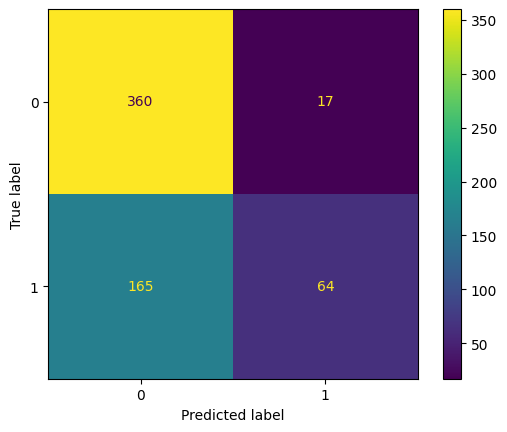

In [15]:
# View them in a confustion matrix
tn, fp, fn, tp = confusion_matrix(y_test, preds1).ravel()

cmd = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, preds1),
                             display_labels=gs.classes_)

cmd.plot();

In [16]:
# Common Metrics

# Specificity
spec = tn / (tn+fp)
print(f'The specificity was {round(spec * 100, 2)} %.')
print('**************************************')

# Sensitivity
print(f'The sensitivity was {round(recall_score(y_test, preds1) * 100, 2)} %.')
print('**************************************')

# Precision
print(f'The precision was {round(precision_score(y_test, preds1) * 100, 2)} %.')
print('**************************************')

# F1 Score
print(f'The F1 score was {round(f1_score(y_test, preds1) * 100, 2)} %.')
print('**************************************')

The specificity was 95.49 %.
**************************************
The sensitivity was 27.95 %.
**************************************
The precision was 79.01 %.
**************************************
The F1 score was 41.29 %.
**************************************


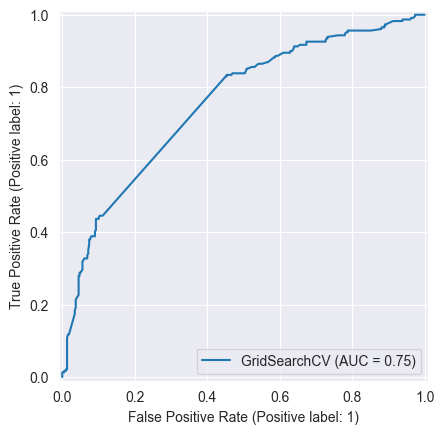

In [29]:
# Roc Curve
sns.set_style('darkgrid')
RocCurveDisplay.from_estimator(gs, X_test, y_test)
plt.legend;
plt.savefig('../assets/rf_cvec_roc_auc.jpg');
plt.show();

In [18]:
# The curve is pretty average, checking the area under the curve
print(f'The ROC AUC score is {round(roc_auc_score(y_test, preds1) * 100, 2)} %. \
     \nThis is a ok score, 1.0 being the best and 0.5 being the worst. \
     \nThis leaves room for improvement.')

The ROC AUC score is 61.72 %.      
This is a ok score, 1.0 being the best and 0.5 being the worst.      
This leaves room for improvement.


### Random Forest with CVEC Evaluation

This model did not perform as well as the Multinomial Naive Bayes models.  Right around 70% on both training and testing data suggest a large amount of underfitting.  The specificity riding high at 95%, the F1 score around 41% , and a ROC AUC just over 61% leaves a model performing not much better han the null model, just guessing.

___
# 08 - Random Forest with TVEC
___

In [19]:
# Building a pipeline for Logisitc Regression with TVEC

pipe2 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

In [20]:
# Setting up hyperparameters to explore
pipe2_parameters = {
    'tvec__max_features': range(60, 100, 10),
    'tvec__min_df': [0, 2],
    'tvec__max_df': [0.20, 0.25, 0.30],
    'tvec__stop_words': [None, 'english'],
    'rf__n_estimators': [10, 20, 30],
    'rf__random_state': [27],
    'rf__max_depth': [8, 10, 12],
}    

In [21]:
# Grid Search for best configuration
gs2 = GridSearchCV(pipe2, 
                 pipe2_parameters,
                 n_jobs=-1,
                  cv=5
                 )

gs2.fit(X_train, y_train)

C:\Users\paddy\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
1080 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1080 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\paddy\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\paddy\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paddy\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 471, in fit
    Xt = self._fit(X, y

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [8, 10, 12],
                         'rf__n_estimators': [10, 20, 30],
                         'rf__random_state': [27],
                         'tvec__max_df': [0.2, 0.25, 0.3],
                         'tvec__max_features': range(60, 100, 10),
                         'tvec__min_df': [0, 2],
                         'tvec__stop_words': [None, 'english']})

### Evaluate

In [22]:
# The GridSearch best results
pipe2_best_params = pd.Series(gs2.best_params_)
print('================================================')
print(f'The GridSearch best score was {round(gs2.best_score_ * 100, 2)} %.')
print('================================================')
pipe2_best_params

The GridSearch best score was 66.9 %.


rf__max_depth              12
rf__n_estimators           10
rf__random_state           27
tvec__max_df              0.2
tvec__max_features         80
tvec__min_df                2
tvec__stop_words      english
dtype: object

In [23]:
# Scoring results on training and testing set
print(f'Training data score: {round(gs2.score(X_train, y_train) *100, 2)} %.')
print(f'Testing data score: {round(gs2.score(X_test, y_test) *100, 2)} %.')

Training data score: 71.59 %.
Testing data score: 67.99 %.


In [24]:
# Evaluate predictions
preds2 = gs2.predict(X_test)

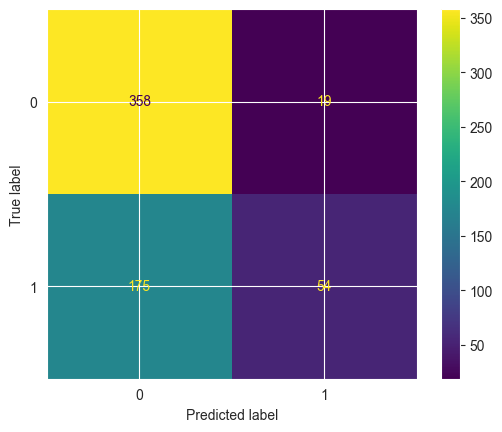

In [25]:
# View them in a confustion matrix
tn2, fp2, fn2, tp2 = confusion_matrix(y_test, preds2).ravel()

cmd2 = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, preds2),
                             display_labels=gs2.classes_)

cmd2.plot();

In [26]:
# Common Metrics

# Specificity
spec2 = tn2 / (tn2+fp2)
print(f'The specificity was {round(spec2 * 100, 2)} %.')
print('**************************************')

# Sensitivity
print(f'The sensitivity was {round(recall_score(y_test, preds2) * 100, 2)} %.')
print('**************************************')

# Precision
print(f'The precision was {round(precision_score(y_test, preds2) * 100, 2)} %.')
print('**************************************')

# F1 Score
print(f'The F1 score was {round(f1_score(y_test, preds2) * 100, 2)} %.')
print('**************************************')

The specificity was 94.96 %.
**************************************
The sensitivity was 23.58 %.
**************************************
The precision was 73.97 %.
**************************************
The F1 score was 35.76 %.
**************************************


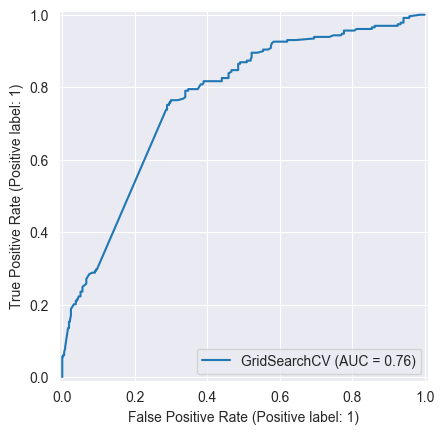

In [27]:
# Roc Curve
RocCurveDisplay.from_estimator(gs2, X_test, y_test)
plt.legend;
plt.show();

In [28]:
# The curve is quite squre, checking the area under the curve
print(f'The ROC AUC score is {round(roc_auc_score(y_test, preds2) * 100, 2)} %. \
     \nThis is a worse score, 1.0 being the best and 0.5 being the worst.')

The ROC AUC score is 59.27 %.      
This is a worse score, 1.0 being the best and 0.5 being the worst.


### Random Forest with TVEC Evaluation

This model did not perform as well as the Multinomial Naive Bayes models.  The 62% on both training and testing data suggest a large amount of underfitting.  The specificity at 100%, the F1 score near 0% , and a ROC AUC just above 50% leaves a model performing worse than the null model, just guessing.